In [47]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth, KMeans, OPTICS, cluster_optics_dbscan, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import pandas as pd
import numpy as np

In [48]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df = df.fillna(df.mean())
df.info()
df['bmi']
# df['stroke']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


C:\Users\edwar\AppData\Local\Temp\ipykernel_11584\98643372.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


0       36.600000
1       28.893237
2       32.500000
3       34.400000
4       24.000000
          ...    
5105    28.893237
5106    40.000000
5107    30.600000
5108    25.600000
5109    26.200000
Name: bmi, Length: 5110, dtype: float64

In [52]:
x = df.iloc[:,[2,9,11]]
x = np.array(x)
x

array([[67.        , 36.6       ,  1.        ],
       [61.        , 28.89323691,  1.        ],
       [80.        , 32.5       ,  1.        ],
       ...,
       [35.        , 30.6       ,  0.        ],
       [51.        , 25.6       ,  0.        ],
       [44.        , 26.2       ,  0.        ]])

In [70]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

x1 = df[['bmi']]
y = df['stroke']

# x1 = x1[:,np.newaxis]

# x_train, x_test, y_train, y_test = train_test_split(x1, x2, random_state=0)

# y_train_binned = np.digitize(y_train,bins=[i])


svm = SVC(kernel='rbf', random_state=0, gamma=0.5, C=1)

svm.fit(x1,y)

y_pred = svm.predict(x1)

accuracy = metrics.accuracy_score(y,y_pred)
precision = metrics.precision_score(y,y_pred)
class_report = metrics.classification_report(y,y_pred)

print(accuracy)
print(precision)
print(class_report)


0.9512720156555773
0.0
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\edwar\AppData

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\edwar\AppData

0.9512720156555773
0.0
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



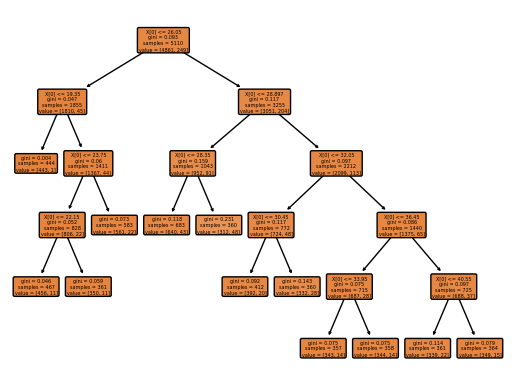

In [69]:
from sklearn import tree
import graphviz

dt = tree.DecisionTreeClassifier(min_samples_leaf=350)
dt = dt.fit(x1,y)

# tree.plot_tree(dt)

dot_data = tree.export_graphviz(dt, out_file=None)
tree.plot_tree(dt, filled=True, rounded=True)

accuracy = metrics.accuracy_score(y,y_pred)
precision = metrics.precision_score(y,y_pred)
class_report = metrics.classification_report(y,y_pred)

print(accuracy)
print(precision)
print(class_report)

In [7]:
db = DBSCAN(eps=0.3, min_samples=10).fit(x)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

Estimated number of clusters: 11
Estimated number of noise points: 4981


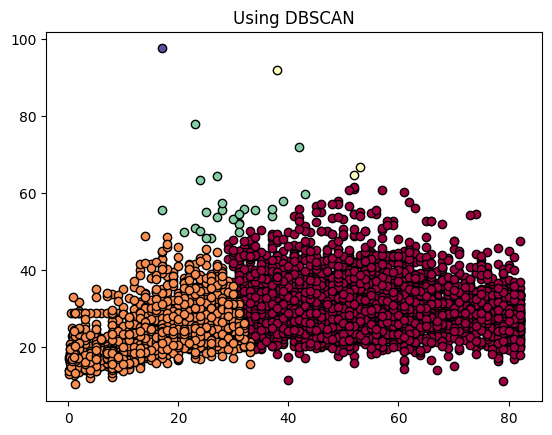

In [71]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="green",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Using DBSCAN")
plt.show()


In [36]:
bandwidth = estimate_bandwidth(x, quantile=0.2,n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print(f"Number of estimated clusters: {n_clusters_}")

Number of estimated clusters: 5


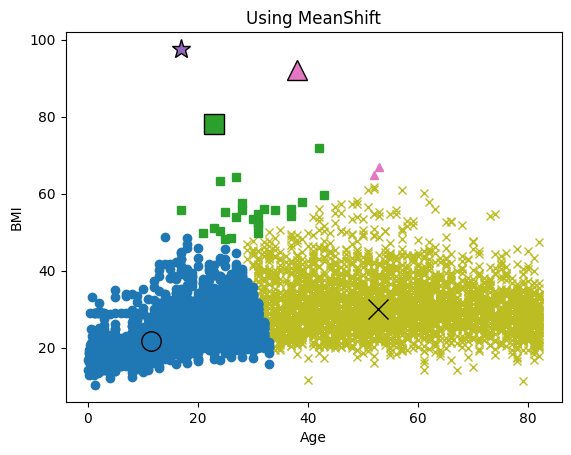

In [37]:
plt.figure(1)
plt.clf()

colors = ["tab:olive", "tab:blue", "tab:pink","tab:green", "tab:purple", "tab:cyan"]

markers = ["x", "o", "^", "s", "*", "+"]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(x[my_members, 0], x[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Using MeanShift")

plt.xlabel("Age")
plt.ylabel('BMI')
plt.show()

In [11]:
km = KMeans(n_clusters=2,
init = 'random', n_init = 5,
max_iter = 100, tol = 0.01)

y_km = km.fit_predict(x)

print(x[y_km == 0,0])

[42. 39. 38. ... 18. 13. 35.]


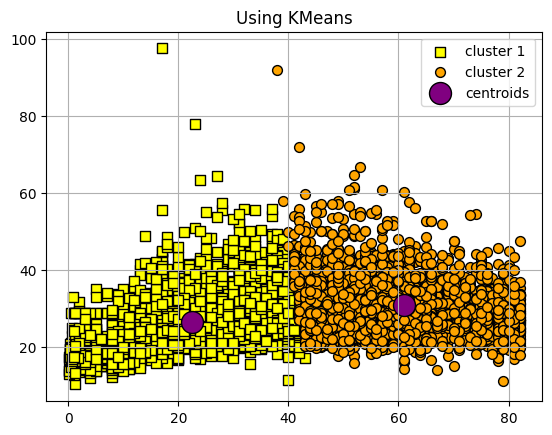

In [12]:
plt.scatter(
    x[y_km == 0,0], x[y_km == 0,1], s=50, c='yellow', marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    x[y_km == 1, 0], x[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    km.cluster_centers_[:,0], km.cluster_centers_[:,1],
    s=250,edgecolors="black", c='purple',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.title("Using KMeans")
plt.grid()
plt.show()

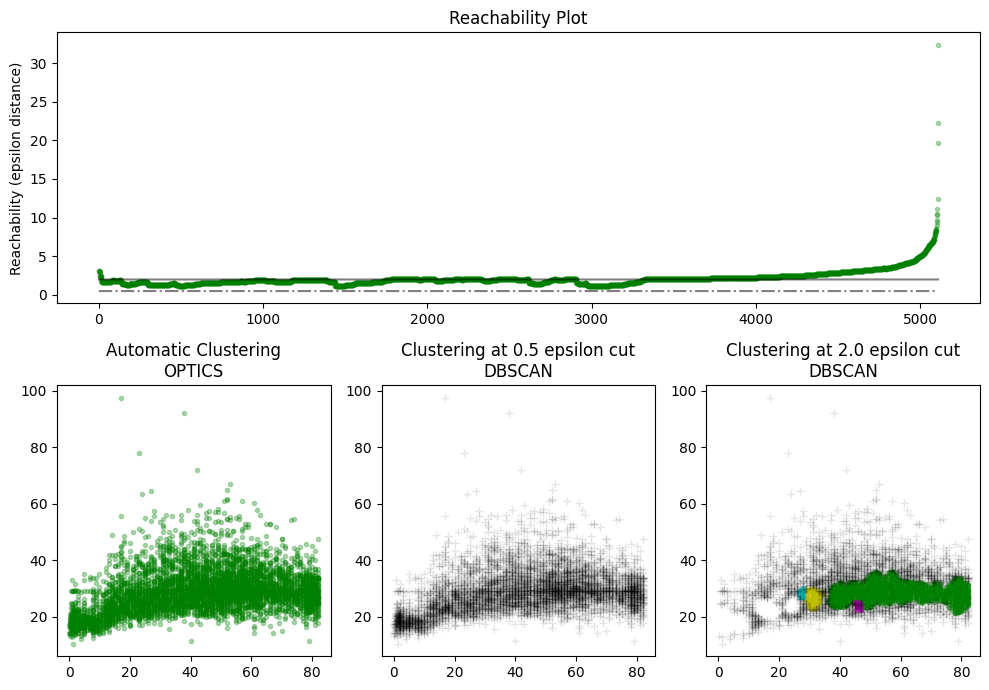

In [13]:
clust = OPTICS(min_samples=50,xi=0.05,min_cluster_size=0.05)

clust.fit(x)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(x))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gs.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = x[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(x[clust.labels_ == -1, 0], x[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = x[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(x[labels_050 == -1, 0], x[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = x[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(x[labels_200 == -1, 0], x[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass v

Estimated number of clusters: 218
Homogeneity: 0.513
Completeness: 0.550
V-measure: 0.531
Adjusted Rand Index: 0.040
Adjusted Mutual Information: 0.163
Silhouette Coefficient: 0.475


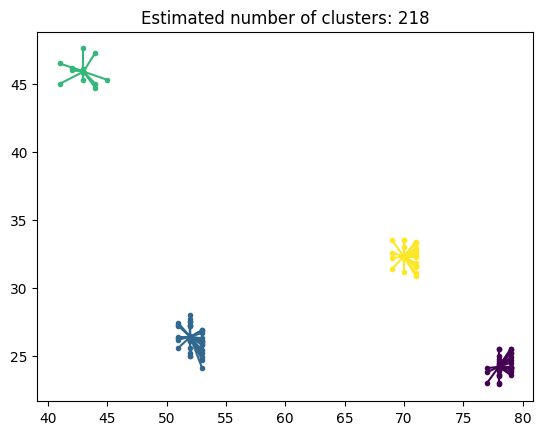

In [14]:
af = AffinityPropagation(preference=-50, random_state=0).fit(x)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

x1 = df['bmi']

print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(x1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(x1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(x1, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(x1, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(x1, labels)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(x, labels, metric="sqeuclidean")
)

plt.close("all")
plt.figure(1)
plt.clf()

colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 4)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = x[cluster_centers_indices[k]]
    plt.scatter(
        x[class_members, 0], x[class_members, 1], color=col["color"], marker="."
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
    )
    for i in x[class_members]:
        plt.plot(
            [cluster_center[0], i[0]], [cluster_center[1], i[1]], color=col["color"]
        )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()


[0.11106353]


C:\Users\edwar\AppData\Local\Temp\ipykernel_11584\3319136409.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x1 = x1[:,np.newaxis]


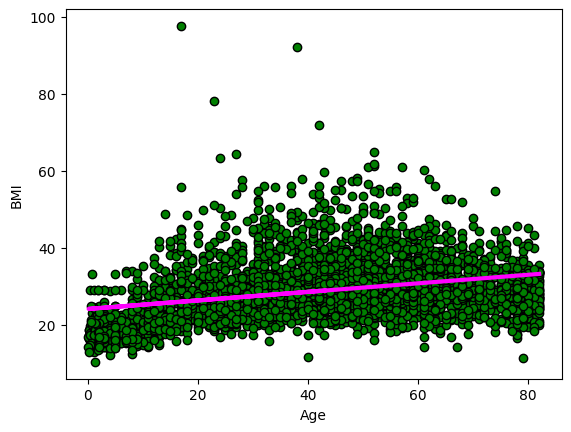

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x1 = df['age']
x2 = df['bmi']

x1 = x1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, x2, random_state=0)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.coef_)

y_pred = lr.predict(x_test)

plt.scatter(x_train, y_train, color='green', edgecolors='black')
plt.plot(x_test, y_pred, color="magenta", linewidth=3)

plt.xticks()
plt.yticks()

plt.xlabel("Age")
plt.ylabel("BMI")

plt.show()


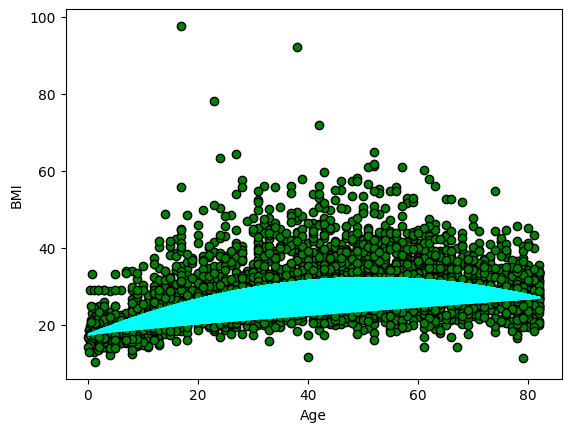

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(x_train)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly,y_train)

y_pred = poly_reg_model.predict(poly_reg.fit_transform(x_test))

plt.scatter(x_train, y_train,color='green',edgecolors='black')
plt.plot(x_test,y_pred, color='cyan')

plt.xlabel("Age")
plt.ylabel("BMI")

plt.show()